In [414]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from scipy.optimize import fsolve, curve_fit
from scipy import interpolate
import math

In [584]:
class WeirFlow:
    """Class for Weir Flow calculations.
    Attributes:
        L - length of weir [ft]
        P - height of weir from bottom to crest [ft].
        rating - weir rating curve, pandas table.
        Co - weir coefficients as a function of P/Ho, where Ho is the height of water above weir crest.
    """
    def __init__(self, L, P):
        self.L = L
        self.P = P
        self.rating = None
        
        # Weir coefficients. USBR Fig. 9-23.
        x = [0., 0.03, 0.08, 0.13, 0.19, 0.27, 0.32, 0.39, 0.5, 0.69, 1, 1.3, 1.5, 1.79, 2.5, 2.8, 2.99, 2.29, 2.99]        
        y = [3.08, 3.2, 3.35, 3.45, 3.55, 3.65, 3.7, 3.75, 3.8, 3.85, 3.89, 3.91, 3.92, 3.93, 3.94, 3.94, 3.94, 3.94, 3.94]
        self.Co = pd.DataFrame(data={'P/Ho':x, 'Co':y})
    
    def Qogee(self, Ho, Co=None):
        """Discharge over an uncontrolled over-flow ogee crest. USBR Fig. 9-23.
        Parameters:
        Ho - height of water above weir crest [ft].
        Co - weir discharge coefficient, if None calculates using Fig. 9-23.
        """
        # If no coefficient is specified, generate one.
        if Co is None:
            Co = np.interp(self.P/Ho, self.Co['P/Ho'], self.Co['Co'])
            
        Q = Co * self.L * Ho**(3/2)
        return Q
    
    def calc_rating(self, dH, Co=None, N=100):
        """Weir ogee crest rating curve.
        Parameters:
        dH - max height above weir crest.
        Co - weir discharge coefficient, if None calculates using Fig. 9-23.
        N - number of calculation points.
        """
        heights = np.linspace(0.001, dH, N)
        Q = self.Qogee(heights, Co=Co)
        self.rating = pd.DataFrame(data={'height':heights, 'Q':Q})
        return self.rating
    
    def save_rating(self, fname='rating_weir.csv'):
        self.rating.to_csv(fname)

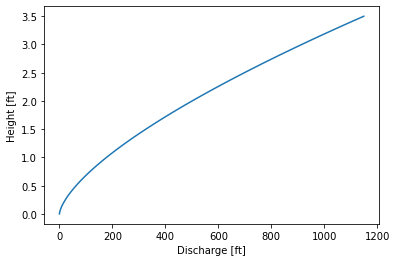

In [585]:
# Example - Weir rating curve

weir = WeirFlow(45, 3.9)
weir.calc_rating(3.5)
weir.save_rating()
plt.plot(weir.rating.Q, weir.rating.height)
plt.xlabel('Discharge [ft]')
plt.ylabel('Height [ft]')
plt.show()

In [586]:
class ShaftFlow():
    """Class for Shaft Spillway / Drop Inlet Flow calculations. USBR Fig. 9-57.
    Attributes:
        diam - diameter [ft].
        P - shaft lip/nape height [ft].
        radius - radius [ft].
        L - drop inlet circumference [ft].
    """
    def __init__(self, diam, P):
        self.diam = diam
        self.P = P
        self.radius = diam/2
        self.L = 2*np.pi*self.radius
        
    def C_015(self, x):
        """
        Returns the discharge coefficient (Co = Q/L*Ho**(3/2)) for P/Rs = 2.
        """
        xp = [0.18, 0.27, 0.34, 0.45, 0.54, 0.61, 0.67, 0.74, 0.81, 
              0.91, 1.02, 1.12, 1.27, 1.42, 1.54, 1.65, 1.83, 2.00]
        yp = [4.04, 3.92, 3.81, 3.66, 3.47, 3.31, 3.14, 2.89, 2.67, 
              2.38, 2.18, 1.97, 1.74, 1.56, 1.44, 1.34, 1.21, 1.12]
        return np.interp(x, xp, yp)
        
    def C_200(self, x):
        """
        Returns the discharge coefficient (Co = Q/L*Ho**(3/2)) for P/Rs = 0.15.
        """
        xp = [0.18, 0.26, 0.33, 0.38, 0.43, 0.49, 0.55, 0.62, 0.67, 0.72, 0.78, 0.86, 
             0.94, 1.02, 1.09, 1.16, 1.25, 1.35, 1.47, 1.58, 1.78, 1.90, 2.00]
        yp = [3.92, 3.81, 3.71, 3.61, 3.50, 3.37, 3.23, 3.05, 2.88, 2.71, 2.51, 2.32, 
             2.14, 2.00, 1.88, 1.77, 1.64, 1.52, 1.40, 1.30, 1.15, 1.07, 1.02]
        return np.interp(x, xp, yp)
    
    def Co(self, P, radius, Ho):
        """
        Interpolates for discharge coefficient based on nape dimensions.
        Co = fcn(P, radius)
        """
        x = Ho/radius
        C = (P/radius - 0.15) * (self.C_015(x) - self.C_200(x))/(2 - 0.15) + self.C_015(x)
        return C
    
    def Qdrop(self, Ho):
        """ Shaft spillway/drop inlet discharge. USBR Fig. 9-57.
        Parameters:
        Ho - height of water above nape crown [ft].
        """
        Q = self.Co(self.P, self.radius, Ho) * self.L * Ho**(3/2)
        return Q
    
    def calc_rating(self, dH, N=100):
        """Shaft spillway/drop inlet rating curve.
        Parameters:
        dH - max height above drop inlet.
        N - number of calculation points.
        """
        heights = np.linspace(0.001, dH, N)
        Q = self.Qdrop(heights)
        self.rating = pd.DataFrame(data={'height':heights, 'Q':Q})
        return self.rating
    
    def save_rating(self, fname='rating_drop_shaft.csv'):
        self.rating.to_csv(fname)

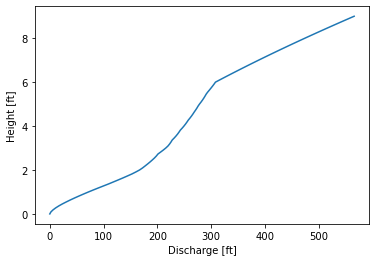

In [587]:
# Example - Drop Inlet

drop = ShaftFlow(72/12, 0)
drop.calc_rating(9)
drop.save_rating()
plt.plot(drop.rating.Q, drop.rating.height)
plt.xlabel('Discharge [ft]')
plt.ylabel('Height [ft]')
plt.show()

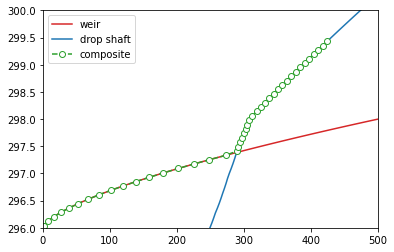

In [588]:
# Example - Composite of weir and drop shaft (Weir to box with drop shaft spillway)

el_weir_crest = 296
el_drop_crest = 292

x = np.linspace(292, 300, 100)
f1 = interpolate.interp1d(el_weir_crest + weir.rating.height, weir.rating.Q, bounds_error=False)
f2 = interpolate.interp1d(el_drop_crest + drop.rating.height, drop.rating.Q, bounds_error=False)
df = pd.DataFrame(data={'Q':[min(x1,x2) for x1, x2 in zip(f1(x), f2(x))], 
                        'elev':x}).dropna()

plt.plot(weir.rating.Q, el_weir_crest + weir.rating.height, c='tab:red', label='weir')
plt.plot(drop.rating.Q, el_drop_crest + drop.rating.height, c='tab:blue', label='drop shaft')
plt.plot(df.Q, df.elev, 'o--', c='tab:green', mfc='w', label='composite')
plt.xlim(left=0, right=500)
plt.ylim(bottom=296, top=300)
plt.legend()
plt.show()

df.to_csv('composite_weir_drop_shaft.csv')

In [689]:
class PressurizedFlow:
    """Class for Pressurized Flow calculations.
    """
    def __init__(self):
        self.GRAVITY = 32.2  # ft/s^2
        self.K_MINOR_COEFF = {'Inward Projecting Inlet': 0.78, 
                            'Sharp Corner Inlet': 0.50, 
                            'Bell Mouth Inlet': 0.04, 
                            'Exit': 1.0,
                            'Gate Valve (Wide Open)': 0.39, 
                            'Gate Valve (Half Open)': 1.10, 
                            'Gate Valve (Quarter Open)': 2.7,
                            'Tee': 1.8,
                            '90 Elbow': 0.9, 
                            '45 Elbow': 0.4}
        
    def hm_bend(self, Q, K, A, delta):
        """Bend losses in circular conduits [ft].
        Parameters:
        Q - flow/discharge [ft^3/s]
        K - minor loss term [-]
        A - pipe area [ft^2]
        delta - degree of curvature/deflection angle [deg]
        """
        K_b = 0.25 * np.sqrt(delta/90)
        return K_b * (Q**2)/(2 * self.GRAVITY * (A**2))
    
    def hm_contract(self, V1, V2, keyword=None):
        """Transition losses due to contraction [ft].
        Parameters:
        V1 - velocity upstream of transition.
        V2 - velocity downstream of transition.
        keyword - keyword describing type of contraction: 'gradual' or 'abrupt'.
        """
        if keyword == 'gradual':
            K_t = 0.10
        elif keyword == 'abrupt':
            K_t = 0.50
        else: 
            K_t = 0.3
        return K_t*(V1**2 - V2**2)/(2 * self.GRAVITY)
        
    def hm_enlarge(self, V1, V2, theta=1.0):
        """Transition losses due to sudden enlargement [ft].
        Parameters:
        V1 - velocity upstream of transition.
        V2 - velocity downstream of transition.
        theta - expansion angle
        """
        thetas = [2, 5, 10, 12, 15, 25, 30, 40, 90]
        Kts = [0.03, 0.04, 0.08, 0.1, 0.16, 0.4, 0.49, 0.6, 1.0]
        K_t = np.interp(theta, thetas, Kts)
        return K_t*(V1**2 - V2**2)/(2 * self.GRAVITY)
        
    def hm_gate_valve(self, keyword):
        """Gate and Valve energy loses [ft].
        Parameters:
        keyword - lookup key for K_MINOR_COEFF.
        """
        return self.K_MINOR_COEFF[keyword]
        
    def hf_friction(self, Q, L, C, D, A):
        """Hazen William's equation for friction loss. Returns friction loss [ft].
        Parameters:
        Q - flow/discharge [ft^3/s]
        L - pipe length [ft]
        C - pipe roughness [-]
            Brick Sewer - 100
            Concrete - 120-140
            Galvanized Iron - 120
            Copper - 130-140
            Plastic - 140-150
            Steel - 145-150
        D - pipe diameter [ft]
        A - pipe area [ft^2]
        Returns:
        hf - friction losses [ft].
        """
        # Either form works.
        # hf = (np.sign(Q)*np.abs(Q)**1.85 * L)/(1.67 * C**1.85 * A**1.85 * (D/4)**1.17) 
        hf = (np.sign(Q)*np.abs(Q)**1.852 * 3.022) * (L/(C**1.852 * D**1.165 * A**1.852))
        return hf
    
    def hm_minor(self, Q, K, A):
        """Returns minor losses [ft].
        Q - flow/discharge [ft^3/s]
        K - minor loss term [-]
        A - pipe area [ft^2]
        Returns: 
        hm - minor losses [ft].
        """
        hm = K * np.sign(Q)*np.abs(Q)**2 / (2 * self.GRAVITY * A**2)
        return hm
        
    def pressurized_equations(self, Q, *known_constants):
        """
        Defines the Energy or Extended Bernoulli Equation used for pressurized calculations.
        
        The energy equation is given by:
        p1/(rho*g) + Q1^2/(2*g*A^2) + z1 = p2/(rho*g) + Q2^2/(2*g*A^2) + z2 + hf_12(Q) + hm_12(Q)
        
        On rearrangement:
        p2/(rho*g) - p1/(rho*g) + z2 - z1 + Q2^2/(2*g*A^2) - Q1^2/(2*g*A^2) + hf_12(Q) + hm_12(Q) = 0
        
        Assuming p1 = p2 = patm, V1 = Q1 = 0:
        z2 - z1 + Q2^2/(2*g*A^2) + hf_12(Q) + hm_12(Q) = 0 
        
        where, 
            Section 1 is upstream. Section 2 is downstream. 
            hf_12(Q) and hm_12(Q) are the friction and minor losses, respectively.
        
        Note: Numpy does not allow fractional powers of negative numbers, even 
        if the power would not result in a complex number. This can lead to errors
        when using fsolve. Work around for Q**2 is np.sign(Q)*np.abs(Q)**2.
        """
        L, D, A, C, K, z2, z1 = known_constants
        hV = (np.sign(Q)*np.abs(Q)**2)/(2 * self.GRAVITY * (A**2))
        hf = self.hf_friction(Q, L, C, D, A)
        hm = self.hm_minor(Q, K, A)
        return  (z2 - z1 + hV + hf + hm)
    
    def solve_pressurized_eq(self, L, D, A, C, K, z2, z1):
        """
        Solves pressurized system of equations for discharge Q.
        """
        known_constants = (L, D, A, C, K, z2, z1)
        Q_o = 1
        Q =  fsolve(self.pressurized_equations, Q_o, args=known_constants)
        return Q


class UnpressurizedFlow:
    """Class for Unpressurized Flow calculations.
    Based on Manning's equation for open channel Flow.
    Some orifice flow equations as well.
    """
    def __init__(self):
        self.GRAVITY = 32.2   # ft/s^2
    
    def Qmann(self, n, A_flow, R_h, S):
        """Manning's Equation for Open Channel Flow, US Equation
        Parameters:
        n - Manning's friction coefficient [-]
            https://www.hec.usace.army.mil/confluence/rasdocs/ras1dtechref/latest/modeling-culverts/culvert-data-and-coefficients/manning-s-roughness-coefficient
        A_flow - flow area [ft2] v
        Rh - hydraulic radius [ft] 
        S - slope [-] 
        Returns:
        Q - flow/discharge [ft^3/s]
        """
        Q = (1.49/n)*A_flow*(R_h**(2/3))*(S**0.5)
        return Q
    
    def Rh_circ(self, y, r):
        """Returns the hydraulic radius for circular pipe.
        Parameters:
        y - depth of water in pipe [ft]
        r - radius of pipe [ft]
        """
        if y <= r:
            h = y
            theta = 2 * np.arccos((r - h)/r)
            A = (r**2) * (theta - np.sin(theta)) / 2
            P = r * theta
            R_h = A/P
        elif (y > r) and (y < 2 * r):
            h = 2 * r - y
            theta = 2 * np.arccos((r-h)/r)
            A = np.pi*(r**2) - (r**2 * (theta - np.sin(theta)))/ 2
            P = 2*np.pi*r - r*theta
            R_h = A/P
        else:
            R_h = 2*r//4
        return R_h
    
    def A_flow_circ(self, y, r):
        """Returns the flow area for circular pipe.
        y - depth of water in pipe [ft]
        r - radius of pipe [ft]
        """
        if y <= r:
            h = y
            theta = 2 * np.arccos((r - h)/r)
            A = (r**2) * (theta - np.sin(theta)) / 2
        elif (y > r) and (y < 2 * r):
            h = 2 * r - y
            theta = 2 * np.arccos((r-h)/r)
            A = np.pi*(r**2) - (r**2 * (theta - np.sin(theta)))/ 2
        else:
            A = np.pi*(r**2)
        return A
    
    def chord_circ(self, y, r):
        """Returns the top chord for a circular pipe.
        y - depth of water in pipe [ft]
        r - radius of pipe [ft]
        """
        if y <= r:
            h = y
            c = 2*np.sqrt(r**2 - (r-h)**2)
        elif (y > r) and (y < 2 * r):
            h = 2*r - y
            c = 2*np.sqrt(r**2 - (r-h)**2)
        else:
            c = r
        return c
    
    def Q_orifice(self, A, H, Cd=0.60):
        """Equation for orifice flow. May be less than Bernoulli's equation for when the
        resevoir has been drained.
        Parameters:
        A - area of pipe [ft^2]
        H - height difference from upstream resevoir to downstream outlet tailwater [ft]
        Cd = Qactual/Qtheoretical (0.6-1.0 typical) = 0.6 default
        """
        Q = Cd * A *np.sqrt(2 * self.GRAVITY * H) 
        return Q

    
class Section:
    """"Class for organizing Section data.
    """
    def __init__(self, length, diam):
        self.diam = diam
        self.length = length
        self.radius = self.diam/2
        self.area = (np.pi/4)*self.diam**2
        self.n = None
        self.slope = None
        self.C = None
        self.K = None
        self.z1 = None
        self.z2 = None
        self.rating_orifice = None
        self.rating_open = None
        self.rating_press = None
        self.critical_info = None
        
    def set_length(self, length):
        """Sets the length [ft]"""
        self.length = length
        
    def set_diam(self, diam):
        """Sets the area [ft] and updates radius and area."""
        self.diam = diam
        self.radius = self.diam/2
        self.area = (np.pi**2/4)*self.diam**2
        
    def set_area(self, area):
        """Sets the area [ft^2], and updates radius and diameter."""
        self.area = area
        self.diam = np.sqrt(4*self.area/np.pi)
        self.radius = self.diam/2
        
    def set_unpressurized_params(self, n, slope):
        """Sets the unpressurized (open channel) parameters.
        Parameters:
        n - roughness coefficient [-]
        slope - channel slope [-]
        """
        self.n = n
        self.slope = slope
    
    def set_pressurized_params(self, C, K, z1, z2):
        """
        Parameters:
        C - pipe roughness coefficient for estimating friction losses with Hazen-Williams Eq.'s [-]
        K - loss coefficient [-]
        z1 - upstream resevoir elevation [ft]
        z2 - downstream outfall elevation [ft]
        """
        self.C = C
        self.K = K
        self.z1 = z1
        self.z2 = z2
        
    def calc_orifice(self, A=None, Cd=0.6, N=1000, H_max=None):
        """Calculates the orifice rating curve.
        Parameters:
        A = orifice area, when None default, uses area.
        Cd = orifice flow coefficient, 0.6 default.
        N = number of calculation points, 100 default.
        H_max = limit for calculation, when None default, calculates up to 1 diameter.
        """
        # Initialize heights.
        if H_max:
            # Calculate up to H_max.
            heights = np.arange(0.001, H_max, (H_max-0.001)/N)
        else:
            # Default, calculate up to 1 diameter.
            heights = np.arange(0.001, self.diam, (self.diam-0.001)/N)
            
        # Initialize areas.
        if not A:
            A = self.area
            
        # Calculate orifice flows.
        oc = UnpressurizedFlow()
        Q = oc.Q_orifice(A, heights, Cd=Cd)
        
        # Save the results.
        df = pd.DataFrame(data={'H':heights, 'Q':Q})
        self.rating_orifice = df
        
    def calc_normal_depth(self, Q_target, N=1000, verbose=True):
        """For a given flow [cfs], calculates the normal depth [ft]. There is the possibility
        of two roots, or depths (subcritical and critical) for a given flow. For the case of
        two roots, returns the one yielding the higher normal depth.
        Parameters:
        Q_target - flow/discharge [cfs].
        N - Calculation points.
        verbose - verbose flag, when true prints no solution if no valid normal depth found.
        Returns:
        Maximum normal depth [ft] for associated target flow, or nan if outside of max feasible range.
        """
        H_arr = np.linspace(0.0001, self.diam-0.0001, 1000)
        Q_arr = np.vectorize(self.calc_manning_flow)(H_arr)

        if Q_target > Q_arr.max():
            if verbose: 
                print("No solution.")
            return np.nan
        else:
            # Finds the index of the two closest candidate flow depths.
            idx_sorted = np.argsort(abs(Q_arr - Q_target))
            idx1, idx2 = idx_sorted[0:2]

            # Uses the index corresponding to the largest flow depth.
            idx = idx1
            if  H_arr[idx2] > H_arr[idx1]:
                idx = idx2
            return H_arr[idx]
    
    def calc_manning_flow(self, depth):
        """Calculates flow [cfs] with Manning's Eq. given normal depth [ft].
        Parameters:
        depth - depth of flow [ft].
        """
        oc = UnpressurizedFlow()
        return oc.Qmann(self.n, oc.A_flow_circ(depth, self.radius), oc.Rh_circ(depth, self.radius), self.slope)
        
    def calc_unpressurized(self, N = 1000):
        """Calculates the unpressurized rating curve.
        Parameters:
        N = number of calculation points, 100 default.
        """
        # Initialize heights.
        depths = np.arange(0.001, self.diam, (self.diam-0.001)/N)

        # Vectorize equations.
        oc = UnpressurizedFlow()
        vA_flow = np.vectorize(oc.A_flow_circ)
        vR_h = np.vectorize(oc.Rh_circ)
        vChord = np.vectorize(oc.chord_circ)

        # Calculates flows.
        Af_arr = vA_flow(depths, self.radius)
        Rh_arr = vR_h(depths, self.radius)
        Chord_arr = vChord(depths, self.radius)
        Q_arr = oc.Qmann(self.n, Af_arr, Rh_arr, self.slope)
        V_arr = Q_arr/Af_arr
        
        # Calculates Froude number. 
        Fr = V_arr/np.sqrt(oc.GRAVITY * self.diam)
        
        # Save unpressurized (open channel) results.
        results = {
            'depths': depths,
            'A_f': Af_arr,
            'R_h': Rh_arr,
            'chord': Chord_arr,
            'Q': Q_arr,
            'V': V_arr, 
            'Fr': Fr
        }
        df = pd.DataFrame(data=results)
        self.rating_open = df
        
        # Save the critical index. 
        crit_idx = (df['Fr'] - 1).abs().argsort()[0]
        self.critical_info = df.iloc[crit_idx]
        
    def calc_pressurized(self, dH, N=1000):
        """Calculates the pressurized rating curve.
        Parameters:
        dH - incremental height of pressure to calculate above z1. 
        N = number of calculation points, 100 default.
        """
        # Initialize heights.
        heights = np.linspace(0.001, dH, N)
    
        # Solve energy equation and calculates flows.
        pf = PressurizedFlow()
        Q_arr = np.zeros(len(heights))
        for i, h in enumerate(heights):
            Q_arr[i] = pf.solve_pressurized_eq(self.length, self.diam, self.area, 
                                               self.C, self.K, self.z2, self.z1 + h)
        # Calculate velocity and velocity head.
        V_arr = Q_arr/self.area
        hV_arr = (V_arr**2)/(2 * pf.GRAVITY)
        
        # Back-calculate friction, minor and total loses in head [ft].
        hf_arr = pf.hf_friction(Q_arr, self.length, self.C, self.diam, self.area)
        hm_arr = pf.hm_minor(Q_arr, self.K, self.area)
        ht_arr = hf_arr + hm_arr
        
        z1_arr = self.z1 + heights
        z2_arr = self.z2*np.ones(len(heights))
        
        # Save pressurized results.
        results = {
            'heights': heights,
            'depths': self.diam + heights,
            'elev': self.z1 + heights,
            'Q': Q_arr,
            'V': V_arr,
            'z1': z1_arr, 
            'z2': z2_arr,
            'hV': hV_arr,
            'hf': hf_arr, 
            'hm': hm_arr, 
            'ht': ht_arr
        }
        df = pd.DataFrame(data=results)
        self.rating_press = df

    def plot_unpressurized(self, key_x, key_y, ax=None, c=None, label=None, show_critical=True):
        """Plots the unpressurized rating curve.
        Parameters:
        key_x - string of x key
        key_y - string of y key
        ax - axes
        c - axis color
        label - label
        show_critical - plot critical points
        """
        # Guard against missing results.
        if self.rating_open is None:
            raise Exception("Must calculate unpressurized results before plotting.")
        
        # Creates new axes handles if none.
        if ax:
            fig = None
        else:
            fig, ax = plt.subplots()
        
        # Plots the results.
        df = self.rating_open
        if c:
            ax.plot(df[key_x], df[key_y], c=c, label=label)
        else:
            ax.plot(df[key_x], df[key_y], label=label)
        if show_critical:
            ax.plot(self.critical_info[key_x], self.critical_info[key_y], 'ko', mfc='w')
        return fig, ax
    
    def plot_pressurized(self, key_x, key_y, ax=None, c=None, label=None):
        """Plots the pressurized rating curve.
        Parameters:
        key_x - string of x key
        key_y - string of y key
        ax - axes
        c - axis color
        label - label
        """
        # Guard against missing results.
        if self.rating_press is None:
            raise Exception("Must calculate pressurized results before plotting.")
        
        # Creates new axes handles if none.
        if ax:
            fig = None
        else:
            fig, ax = plt.subplots()
            
        # Plots the results.
        df = self.rating_press
        if c:
            ax.plot(df[key_x], df[key_y], c=c, label=label)
        else:
            ax.plot(df[key_x], df[key_y])
        return fig, ax
    
    def validate_rating_press(self, plot=True):
        """Validates the rating curve for pressurized flow by checking that it satisfies the
        energy equation (i.e. terms sum to zero). Returns true if terms satisfy the equation.
        """
        if self.rating_press is not None:
            sum_terms = (sec.z2 - 
                         sec.rating_press.elev + 
                         sec.rating_press.hf + 
                         sec.rating_press.hm + 
                         sec.rating_press.Q**2/(2*32.2*sec.area**2)
                        )
            satisfies = np.isclose(all(sum_terms),0)
            print("Satisfies equation?: ", satisfies)
            if plot:
                plt.plot(sum_terms)
            return satisfies
        else:
            print("Must calculate pressurized results.")
    
    def percent_friction_loss(self):
        """Returns the percent friction loss (min, mean, max).
        Typical loss is 1-10 ft per 10000 ft of pipeline (0.1-1%).
        """
        if self.rating_press is not None:
            perc_loss = 100 * sec.rating_press.hf/sec.length
            return perc_loss.min(), perc_loss.mean(), perc_loss.max()
        else:
            print("Must calculate pressurized results.")
    
    def save_unpressurized(self, fname='output_unpressurized.csv'):
        """Save the section unpressurized results to csv file."""
        self.rating_open.to_csv(fname)
    
    def save_pressurized(self, fname='output_pressurized.csv'):
        """Save the section pressurized results to csv file."""
        self.rating_press.to_csv(fname)
        
    def save_orifice(self, fname='output_orifice.csv'):
        """Save the section orifice results to csv file."""
        self.rating_orifice.to_csv(fname)

        
class SectionComposite:
    """Composite Section class. 
    """
    def __init__(self, sections):
        self.sections = sections
        self.pf = PressurizedFlow()
        self.uf = UnpressurizedFlow()
        self.rating_press = None
        self.rating_open = None
        self.rating_comb = None
    
    def pressurized_equations_system(self, Q, *knowns):
        """
        Defines the Energy or Extended Bernoulli Equation used for pressurized calculations.
        
        The energy equation is given by:
        p1/(rho*g) + Q1^2/(2*g*A^2) + z1 = p2/(rho*g) + Q2^2/(2*g*A^2) + z2 + hf_12(Q) + hm_12(Q)
        
        On rearrangement:
        p2/(rho*g) - p1/(rho*g) + z2 - z1 + Q2^2/(2*g*A^2) - Q1^2/(2*g*A^2) + hf_12(Q) + hm_12(Q) = 0
        
        Assuming p1 = p2 = patm, V1 = Q1 = 0:
        z2 - z1 + Q2^2/(2*g*A^2) + hf_12(Q) + hm_12(Q) = 0
        where, 
            Section 1 is upstream. Section 2 is downstream. 
            hf_12(Q) and hm_12(Q) are the friction and minor losses, respectively.
            
        For a composite system made of several sections:
        z_out - z_in + Q2^2/(2*g*A_out^2) + SUM|hf_12(Q) + SUM|hm_12(Q) = 0
        where, 
            z_out and z_in are the tailwater/outlet and headwater/inlet elevations.
            SUM refers to the summation of the terms over all distinct sections/segments.
        
        Note: Numpy does not allow fractional powers of negative numbers, even 
        if the power would not result in a complex number. This can lead to errors
        when using fsolve. Work around for Q**2 is np.sign(Q)*np.abs(Q)**2.
        """
        # Unpack arguments.
        sections, dz = knowns
        
        # Defines the headwater/inlet and tailwater/outlet elevations.
        z1 = sections[0].z1 + dz
        z2 = sections[-1].z2
        
        # Velocity head.
        hV = (np.sign(Q)*np.abs(Q)**2)/(2 * self.pf.GRAVITY * (sections[-1].area**2))
        
        # Defines the friction and minor head loss terms.
        hf_sum = 0  # Friction head loss
        hm_sum = 0  # Minor head loss
        for sec in sections:
            hf_sum += self.pf.hf_friction(Q, sec.length, sec.C, sec.diam, sec.area)
            hm_sum += self.pf.hm_minor(Q, sec.K, sec.area)
        # Compute the energy equation.
        eqn_sum = z2 - z1 + hV + hf_sum + hm_sum
        return  eqn_sum
    
    def solve_pressurized_eq_system(self, dz):
        """
        Solves pressurized system of equations for discharge Q.
        Parameters:
        dz - incremental headwater height (above inlet)
        """
        knowns = (self.sections, dz)
        Q_o = 1
        Q =  fsolve(self.pressurized_equations_system, Q_o, args=knowns)
        return Q
    
    def calc_rating_pressurized(self, dH, N=1000):
        """Computes the pressurized rating curve, relative to the upstream inlet crown.
        Parameters:
        dH - height interval to calculate pressure ratings [ft].
        N - number of calculation points.
        """
        heights = np.linspace(0.001, dH, N)
        Q_arr = np.zeros(len(heights))
        for i, h in enumerate(heights):
            Q_arr[i] = self.solve_pressurized_eq_system(h)
            
        # Back-calculate the velocity, friction loss, and minor loss head terms. 
        hV_arr = np.zeros(len(heights))
        hf_sum = np.zeros(len(heights))
        hm_sum = np.zeros(len(heights))
        for i in range(len(heights)):
            Q = Q_arr[i]
            hV_arr[i] = (np.sign(Q)*np.abs(Q)**2)/(2 * self.pf.GRAVITY * (self.sections[-1].area**2))
            for sec in self.sections:
                hf_sum[i] += self.pf.hf_friction(Q, sec.length, sec.C, sec.diam, sec.area)
                hm_sum[i] += self.pf.hm_minor(Q, sec.K, sec.area)
        ht_sum = hf_sum + hm_sum
        
        elev = heights + self.sections[0].z1
        z1_arr = self.sections[0].z1 + heights
        z2_arr = self.sections[-1].z2*np.ones(len(heights))

        data = {'heights': heights,
                'elev': elev,
                'Q': Q_arr,
                'z1': z1_arr,
                'z2': z2_arr, 
                'hV': hV_arr,
                'hf_sum': hf_sum,
                'hm_sum': hm_sum,
                'ht_sum': ht_sum}
        self.rating_press = pd.DataFrame(data=data)
        return self.rating_press
        
    def calc_rating_unpressurized(self, Hmax=None, N=1000, verbose=False):
        """
        Generates the unpressurized (open channel) rating curve.
        Parameters:
        Hmax - Max height to calculate open channel flow up to [ft] (default diam).
        N - Number of calculation points.
        verbose - boolean flag for displaying when points are pressurized.
        """
        if not Hmax:
            sec1 = self.sections[0]
            Hmax = sec1.diam*0.999
            
        heights = np.linspace(0.001, Hmax)
        Q_arr = np.zeros(len(heights))
        y_mat = np.zeros((len(heights), len(self.sections)))
        Fr_mat = np.zeros((len(heights), len(self.sections)))
        
        # For each headwater height.
        for i, h in enumerate(heights):
            for j, sec in enumerate(self.sections):
                if j == 0:
                    # Solve for Q if first section.
                    A = self.uf.A_flow_circ(h, sec.radius)
                    Rh = self.uf.Rh_circ(h, sec.radius)
                    Q = self.uf.Qmann(sec.n, A, Rh, sec.slope)
                    y = h
                    Q_arr[i] = Q
                    y_mat[i,j] = y
                else:
                    # Solve for normal depths in subsequent sections.
                    y = sec.calc_normal_depth(Q, verbose=verbose)
                    y_mat[i,j] = y

                if verbose and np.isnan(y):
                    print(f"Pressurizes at h:{h:.1f} ft, Q:{Q:.0f} cfs, sec:{j+1%i}, y:{y:.1f} ft")

        # Reshape the 1d arrays for concatenation.
        heights = heights.reshape(len(heights), 1)
        Q_arr = Q_arr.reshape(len(heights),1)
                    
        # Save the composite results.
        #  Horizontally concat into 1 matrix.
        data = np.concatenate((heights, Q_arr, y_mat, Fr_mat), axis=1)
        #  Column names
        indices = range(1, len(self.sections)+1)
        columns = ['headwater', 'Q'] 
        for name in ['y_', 'Fr_']:
            columns += [f"{name}{i}" for i in indices]
        #  Save to dataframe
        self.rating_open = pd.DataFrame(data=data, columns=columns)
        return self.rating_open
        
    def pressurized_at(self, verbose=True):
        """Returns at what flow system becomes pressurized, if applicable, and False otherwise.
        """
        if self.rating_open is None:
            print("No rating curve currently defined. Calculating new curve.")
            self.calc_rating_unpressurized()
        
        df = self.rating_open
        if df.isnull().any(axis=1).any():
            idx = df.isnull().any(axis=1).idxmax() - 1
            Qmax = df.iloc[idx].Q
            if verbose:
                print(f"Pressurized at Qmax: {Qmax:.0f} cfs")
            return Qmax
        else:
            return False
        
    def rating_combined(self, N=1000):
        """
        Returns the combined rating curve.
        Parameters:
        N - number of interpolation points
        """
        if (self.rating_open is None) or (self.rating_press is None):
            print("Pressurized and and Unpressurized rating curves must be generated first.")
            return
        
        # Truncate headwater unpressurized curve where any downstream section becomes pressurized.
        mask = self.rating_open['Q'] <= self.pressurized_at(verbose=False)
        x = pd.concat((self.rating_open['Q'][mask], self.rating_press['Q']))
        y = pd.concat((self.rating_open['headwater'][mask], self.sections[0].diam + self.rating_press['heights']))

        # Linearly interpolate between pressurized and unpressurized flow.
        xnew = np.linspace(x.min(), x.max(), N)
        ynew = np.interp(xnew, x, y)
        
        self.rating_comb = pd.DataFrame(data={'height': ynew, 'Q': xnew})
        return self.rating_comb
    
    def validate_rating_press(self, plot=True):
        """Validates the rating curve for pressurized flow by checking that it satisfies the
        energy equation (i.e. terms sum to zero). Returns true if terms satisfy the equation.
        """
        if self.rating_press is not None:
            sum_terms = (self.sections[-1].z2 - 
                         (self.sections[0].z1 + system.rating_press.heights) +
                         self.rating_press.hV +
                         self.rating_press.hf_sum +
                         self.rating_press.hm_sum
                        )
            satisfies = np.isclose(all(sum_terms),0)
            print("Satisfies equation?: ", satisfies)
            if plot:
                plt.plot(sum_terms)
            return satisfies
        else:
            print("Must calculate pressurized results.")
    
    def percent_friction_loss(self):
        """Returns the percent friction loss (min, mean, max)
        Typical loss is 1-10 ft per 10000 ft of pipeline (0.1-1%).
        """
        if self.rating_press is not None:
            total_length = sum([sec.length for sec in self.sections])
            perc_loss = 100 * self.rating_press.hf_sum/total_length
            return perc_loss.min(), perc_loss.mean(), perc_loss.max()
        else:
            print("Must calculate pressurized results.")
    
    def save_unpressurized(self, fname="system_output_iunpressurized.csv"):
        """Saves the unpressurized results to csv file."""
        self.rating_open.to_csv(fname)
        
    def save_pressurized(self, fname="system_output_pressurized.csv"):
        """Saves the pressurized results to csv file."""
        self.rating_press.to_csv(fname)
        
    def save_combined(self, fname="system_output_combined.csv"):
        """Saves the combined pressurized/unpressurized results to csv file."""
        self.rating_comb.to_csv(fname)

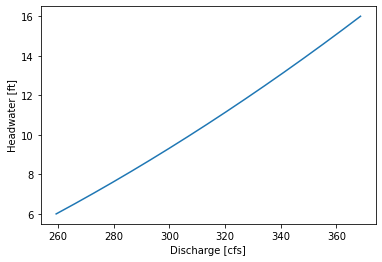

In [624]:
# Example - Pressurized Section

length = 900
diam = 72/12
C = 140
K = 5
z1 = 10
z2 = 0

sec = Section(length, diam)
sec.set_pressurized_params(C, K, z1, z2)
sec.calc_pressurized(10)

fig, ax = plt.subplots()
__, ax = sec.plot_pressurized('Q', 'depths', ax = ax, c='tab:blue')
plt.xlabel('Discharge [cfs]')
plt.ylabel('Headwater [ft]')
plt.show()

Satisfies equation?:  True


(0.24068588559334886, 0.35208351715798564, 0.461967034951185)

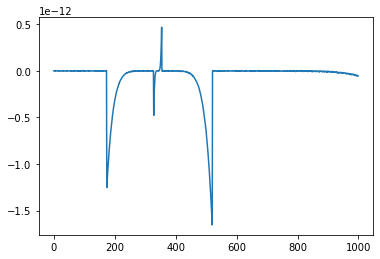

In [625]:
# Check validity of results (sum of energy terms should be near zero)
sec.validate_rating_press(plot=True)
sec.percent_friction_loss()

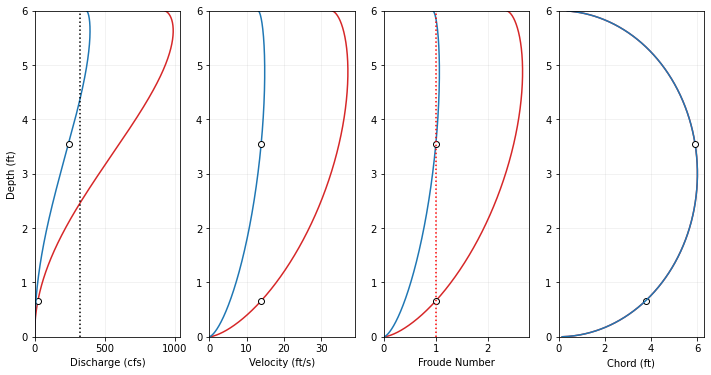

In [688]:
# Example - Comparison Two Unpressurized (Open-Channel) Sections 

sec1 = Section(300, 72/12)
sec2 = Section(600, 72/12)
sec1.set_unpressurized_params(0.012, 0.04)
sec2.set_unpressurized_params(0.012, 0.0064)

sec1.calc_unpressurized()
sec2.calc_unpressurized()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=4)
ax = ax.flatten()
__, ax[0] = sec1.plot_unpressurized('Q', 'depths', ax=ax[0], c='tab:red', label='sec1')
__, ax[0] = sec2.plot_unpressurized('Q', 'depths', ax=ax[0], c='tab:blue', label='sec2')
__, ax[1] = sec1.plot_unpressurized('V', 'depths', ax=ax[1], c='tab:red')
__, ax[1] = sec2.plot_unpressurized('V', 'depths', ax=ax[1], c='tab:blue')
__, ax[2] = sec1.plot_unpressurized('Fr', 'depths', ax=ax[2], c='tab:red')
__, ax[2] = sec2.plot_unpressurized('Fr', 'depths', ax=ax[2], c='tab:blue')
__, ax[3] = sec1.plot_unpressurized('chord', 'depths', ax=ax[3], c='tab:red')
__, ax[3] = sec2.plot_unpressurized('chord', 'depths', ax=ax[3], c='tab:blue')
ax[0].plot([326,326],[0,6], 'k:', label='design')
ax[2].plot([1, 1],[0,6], 'r:', label='critical')
ax[0].set_ylabel('Depth (ft)')
x_labels = ['Discharge (cfs)', 'Velocity (ft/s)', 'Froude Number', 'Chord (ft)']
for i, a in enumerate(ax):
    a.set_xlabel(x_labels[i])
    a.grid(which='both', alpha=0.2)
    a.set_xlim(left=0)
    a.set_ylim(bottom=0, top=6)
plt.show()

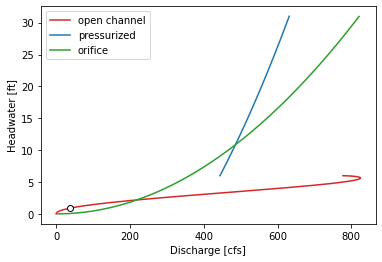

In [627]:
# Example - Pressurized, Open-Channel and Orifice

z1 = 25
z2 = 0
length = 900
diam = 72/12
n = 0.012
dH = z1 - z2
slope = dH/length
C = 140
K = 4

sec = Section(length, diam)
sec.set_unpressurized_params(n, slope)
sec.set_pressurized_params(C, K, z1, z2)

sec.calc_unpressurized()
sec.calc_pressurized(dH)
sec.calc_orifice(A=sec.area, Cd=0.65, H_max=sec.rating_press['depths'].max())

fig, ax = plt.subplots()
__, ax = sec.plot_unpressurized('Q', 'depths', ax = ax, c='tab:red', label='open channel')
__, ax = sec.plot_pressurized('Q', 'depths', ax = ax, c='tab:blue', label='pressurized')

ax.plot(sec.rating_orifice['Q'], sec.rating_orifice['H'], c='tab:green', label='orifice')
plt.xlabel('Discharge [cfs]')
plt.ylabel('Headwater [ft]')
ax.legend()
plt.show()

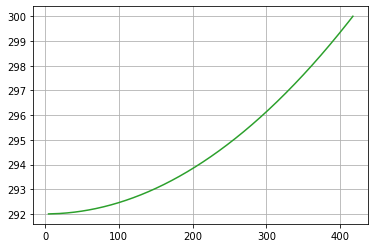

In [669]:
sec.calc_orifice(A=sec.area, Cd=0.65, H_max=8)
plt.plot(sec.rating_orifice['Q'], 292 + sec.rating_orifice['H'], c='tab:green', label='orifice')
plt.grid(which='both')

Pressurized at Qmax: 412 cfs


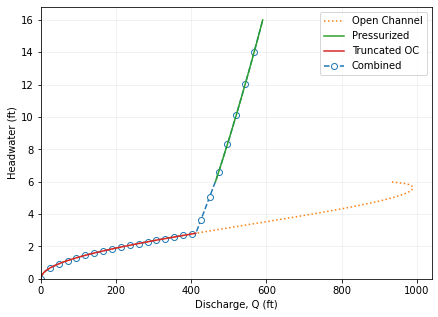

In [630]:
# Example - Two Sections - Combined Pressurized/Unpressurized

pf = PressurizedFlow()

diam1, diam2 = 72/12, 72/12
length1, length2 = 292, 609
n = 0.012
slope1, slope2 = 0.04, 0.0075
C = 140
K1, K2 = 0.25, 1.25
el_1a, el_1b = 278.43 + diam1/2, 266.16
el_2a, el_2b = 266.16, 261.58 + diam2/2


sec1 = Section(length1, diam1)
sec2 = Section(length2, diam2)
sec1.set_unpressurized_params(n, slope1)
sec2.set_unpressurized_params(n, slope2)
sec1.set_pressurized_params(C, K1, el_1a, el_1b)
sec2.set_pressurized_params(C, K2, el_2a, el_2b)

# Compute rating curve
dH = 10
sections = [sec1, sec2]
system = SectionComposite(sections)
rating1 = system.calc_rating_unpressurized(N=1000)
rating2 = system.calc_rating_pressurized(dH, N=1000)
rating_comb = system.rating_combined(N=1000)


fig, ax = plt.subplots(figsize=(7,5))

ax.plot(rating1.Q, rating1.headwater, ':',
        c='tab:orange', label='Open Channel')
ax.plot(rating2.Q, sec1.diam + rating2.heights,
        c='tab:green', label='Pressurized')

mask = rating1.Q <= system.pressurized_at()
ax.plot(rating1.Q[mask], rating1.headwater[mask],
        c='tab:red', label='Truncated OC')

ax.plot(rating_comb.Q, rating_comb.height,
        'o--', markevery=40, mfc='w', zorder=0,
        c='tab:blue', label='Combined')

plt.xlabel('Discharge, Q (ft)')
plt.ylabel('Headwater (ft)')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(alpha=0.2, which='both')
plt.legend()
plt.show()

system.save_combined()

In [633]:
# With partial submergence, suppose pressurization will occur sooner if 
# sec2.z2
# rating1

Satisfies equation?:  True


(0.6336152412911927, 0.8105738812132449, 0.986126726237058)

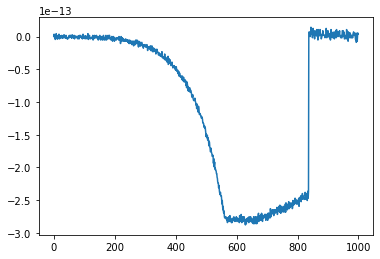

In [426]:
system.validate_rating_press()
system.percent_friction_loss()

In [631]:
system.rating_press

,heights,elev,Q,z1,z2,hV,hf_sum,hm_sum,ht_sum
0,0.001000,281.431000,464.350715,281.431000,264.58,4.188144,6.380640,6.282216,12.662856
1,0.011009,281.441009,464.492575,281.441009,264.58,4.190703,6.384251,6.286055,12.670306
2,0.021018,281.451018,464.634395,281.451018,264.58,4.193263,6.387861,6.289894,12.677755
3,0.031027,281.461027,464.776173,281.461027,264.58,4.195822,6.391471,6.293733,12.685205
4,0.041036,281.471036,464.917911,281.471036,264.58,4.198382,6.395082,6.297573,12.692654
...,...,...,...,...,...,...,...,...,...
995,9.959964,291.389964,589.597362,291.389964,264.58,6.752124,9.929653,10.128187,20.057840
996,9.969973,291.399973,589.710511,291.399973,264.58,6.754716,9.933183,10.132074,20.065257
997,9.979982,291.409982,589.823639,291.409982,264.58,6.757308,9.936712,10.135962,20.072674
998,9.989991,291.419991,589.936747,291.419991,264.58,6.759900,9.940241,10.139850,20.080091


Pressurized at Qmax: 412 cfs
Sec 1 Qmax [cfs]: 990
Sec 2 Qmax [cfs]: 429


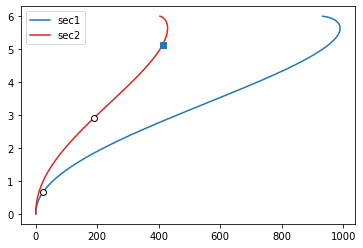

In [428]:
# Check that point of pressurization in the system is consistent. 
# Maximal flow should be constrained by component with minimum capacity.

qt = system.pressurized_at()
yt = sec2.calc_normal_depth(qt)

sec1.calc_unpressurized()
sec2.calc_unpressurized()

fig, ax = plt.subplots()
__, ax = sec1.plot_unpressurized('Q', 'depths', ax = ax, c='tab:blue', label='sec1')
__, ax = sec2.plot_unpressurized('Q', 'depths', ax = ax, c='tab:red', label='sec2')
ax.plot(qt,yt,'s')
plt.legend()
print(f"Sec 1 Qmax [cfs]: {sec1.rating_open.Q.max():.0f}")
print(f"Sec 2 Qmax [cfs]: {sec2.rating_open.Q.max():.0f}")

Text(0, 0.5, 'Elevation [ft]')

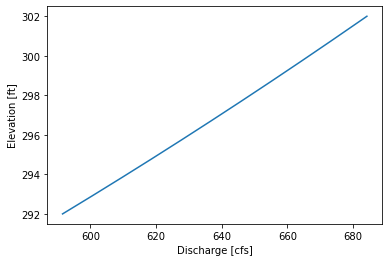

In [634]:
# Example - Three Sections - Pressurized Rating Curve

D = 72/12
L1, L2, L3 = 13, 292, 600
C = 140
K1, K2, K3 = 0.25, 0.5, 1.25
el_1a, el_1b = 292, 278.43
el_2a, el_2b = 278.43, 266.16
el_3a, el_3b = 266.16, 261.58

sec1 = Section(L1, D)
sec2 = Section(L2, D)
sec3 = Section(L3, D)
sec1.set_pressurized_params(C, K1, el_1a, el_1b)
sec2.set_pressurized_params(C, K2, el_2a, el_2b)
sec3.set_pressurized_params(C, K3, el_3a, el_3b)

dH = 10
system_full = SectionComposite([sec1, sec2, sec3])
rating_full = system_full.calc_rating_pressurized(dH)

plt.plot(rating_full.Q, sec1.z1 + rating_full.heights)
plt.xlabel('Discharge [cfs]')
plt.ylabel('Elevation [ft]')

Satisfies equation?:  True


(0.6090048570920272, 0.702351953767531, 0.795151175809527)

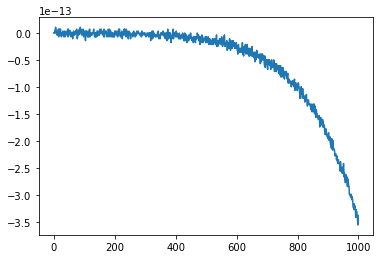

In [430]:
system_full.validate_rating_press()
system_full.percent_friction_loss()

In [431]:
system_full.rating_press

,heights,elev,Q,z1,z2,hV,hf_sum,hm_sum,ht_sum
0,0.001000,292.001000,428.024722,292.001000,261.58,3.558501,5.511494,21.351005,26.862499
1,0.011009,292.011009,428.096086,292.011009,261.58,3.559688,5.513196,21.358125,26.871321
2,0.021018,292.021018,428.167439,292.021018,261.58,3.560874,5.514898,21.365246,26.880144
3,0.031027,292.031027,428.238781,292.031027,261.58,3.562061,5.516600,21.372366,26.888966
4,0.041036,292.041036,428.310111,292.041036,261.58,3.563248,5.518302,21.379487,26.897788
...,...,...,...,...,...,...,...,...,...
995,9.959964,301.959964,494.075614,301.959964,261.58,4.741505,7.189430,28.449030,35.638459
996,9.969973,301.969973,494.137661,301.969973,261.58,4.742696,7.191102,28.456175,35.647277
997,9.979982,301.979982,494.199700,301.979982,261.58,4.743887,7.192774,28.463321,35.656095
998,9.989991,301.989991,494.261732,301.989991,261.58,4.745078,7.194446,28.470467,35.664913


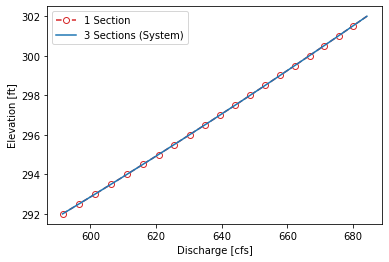

Satisfies equation?:  True


(0.6515146062661236, 0.953599288217812, 1.2516585620473886)

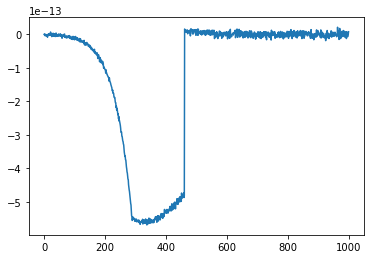

In [635]:
# For pressurized flow, whether we model by a single segment, 
# or multiple segments, we should get the same solution. 
s = Section(L1+L2+L3, D)
s.set_pressurized_params(C, K1+K2+K3, el_1a, el_3b)
s.calc_orifice(H_max=sec.rating_press['depths'].max())
s.calc_pressurized(10)

plt.plot(s.rating_press.Q, s.rating_press.elev, 
         'o--', c='tab:red', mfc='w', markevery=50, label='1 Section')
plt.plot(system_full.rating_press.Q, system_full.rating_press.elev, 
         '-', c='tab:blue', label='3 Sections (System)')
plt.xlabel('Discharge [cfs]')
plt.ylabel('Elevation [ft]')
plt.legend()
plt.show()

s.validate_rating_press()
s.percent_friction_loss()

In [433]:
# Check that loss terms should follow linear superposition.
Q =  1000
C = 140
diam = 72/12 
K1, K2, K3 = 2, 2, 1
area = (np.pi/4) * diam**2
L1, L2, L3 = 100, 300, 1000

pf = PressurizedFlow()
sum1 = pf.hf_friction(Q, L1, C, diam, area) + pf.hf_friction(Q, L2, C, diam, area) + pf.hf_friction(Q, L3, C, diam, area)
sum2 = pf.hf_friction(Q, L1 + L2 + L3, C, diam, area)
print("Friction loss equal?:", np.isclose(sum1, sum2))

sum1 = pf.hm_minor(Q, K1, area) + pf.hm_minor(Q, K2, area) + pf.hm_minor(Q, K3, area)
sum2 = pf.hm_minor(Q, K1 + K2 + K3, area)
print("Minor loss equal?:", np.isclose(sum1, sum2))

Friction loss equal?: True
Minor loss equal?: True


In [481]:
class Discretizer:
    """Class used to discretize CompositeSections. """
    
    def __init__(self):
        pass
    
    def verify_sections(self, sections):
        """Returns a boolean flag indicate if pressurized and unpressurized parameter fields
        have all been populated for each section.
        Parameters:
        sections - list of Section objects.
        """
        for sec in sections:
            if (sec.n is None) and (sec.slope is None):
                print("Must define unpressurized parameters for all sections.")
                return False
            if (sec.C is None) and (sec.K is None) and (sec.z1 is None) and (sec.z2 is None):
                print("Must define pressurized parameters for all sections.")
                return False
        return True

    def discretize(self, sections, dL_target=50):
        """Returns a new composite section that has been discretized.
        Parameters:
        dL_target - target discretization length
        """
        # For each section, set the discretization length.
        if not self.verify_sections(sections):
            return
            
        new_sections = []
        for sec in sections:
            N = int(np.ceil(sec.length/dL_target))
            slope = (sec.z2 - sec.z1)/sec.length
            dL = (sec.length/N)
            dZ = dL * slope
            
            # Instantiate the new segments and let them inherit the parent
            # characteristics, but updated for elevations.
            for i in range(N):
                el_1 = sec.z1 + i * dZ
                el_2 = sec.z1 + (i + 1) * dZ
                
                #  We must also distribute minor losses over the segments!
                K = sec.K/N
                
                new_sec = Section(dL, sec.diam)
                new_sec.set_pressurized_params(sec.C, K, el_1, el_2)
                new_sec.set_unpressurized_params(sec.n, sec.slope)
                
                new_sections += [new_sec]
                
        return SectionComposite(new_sections)
    

diam1, diam2 = 72/12, 72/12
length1, length2 = 292, 609
n = 0.012
slope1, slope2 = 0.04, 0.0075
C = 140
K1, K2 = 1, 1
el_1a, el_1b = 278.43, 266.16
el_2a, el_2b = 266.16, 261.58

sec1 = Section(length1, diam1)
sec2 = Section(length2, diam2)
sec1.set_unpressurized_params(n, slope1)
sec2.set_unpressurized_params(n, slope2)
sec1.set_pressurized_params(C, K1, el_1a, el_1b)
sec2.set_pressurized_params(C, K2, el_2a, el_2b)

dH = 10
outlet_base = SectionComposite([sec1, sec2])
rating_base_p = outlet_base.calc_rating_pressurized(dH)
rating_base_o = outlet_base.calc_rating_unpressurized()

Pressurized at Qmax: 412 cfs
Pressurized at Qmax: 412 cfs


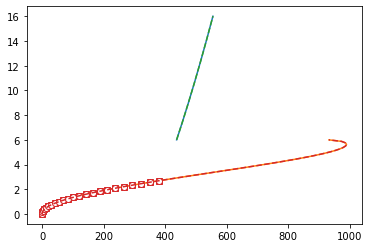

In [482]:
# Discretization length should not affect open channel or pressurized solutions. Good!

for dL in [150]:
    outlet = Discretizer().discretize([sec1, sec2], dL_target=dL)

    rating_p = outlet.calc_rating_pressurized(dH)
    rating_o = outlet.calc_rating_unpressurized()

    plt.plot(rating_p.Q, outlet.sections[-1].diam + rating_p.heights)
    plt.plot(rating_o.Q, rating_o.headwater)

    mask = rating_o.Q < outlet.pressurized_at()
    plt.plot(rating_o.Q[mask], rating_o.headwater[mask],
            'o', mfc='w', c='tab:red',  label='Truncated OC')


plt.plot(rating_base_p.Q, outlet_base.sections[-1].diam + rating_base_p.heights, '--')
plt.plot(rating_base_o.Q, rating_base_o.headwater, '--')
mask = rating_base_o.Q < outlet_base.pressurized_at()
plt.plot(rating_base_o.Q[mask], rating_base_o.headwater[mask],
        's', mfc='w', c='tab:red',  label='Truncated OC', zorder=0)
plt.show()

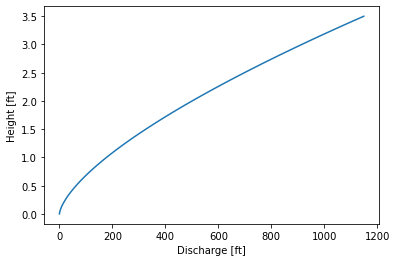

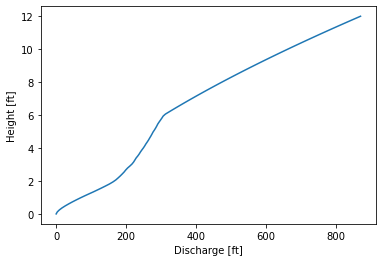

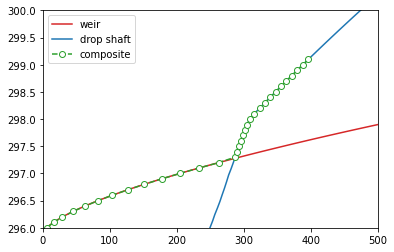

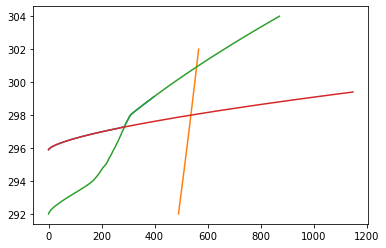

In [664]:
# Weir
weir = WeirFlow(45, 3.9)
weir.calc_rating(3.5)
weir.save_rating()
plt.plot(weir.rating.Q, weir.rating.height)
plt.xlabel('Discharge [ft]')
plt.ylabel('Height [ft]')
plt.show()

# Shaft
drop = ShaftFlow(72/12, 0)
drop.calc_rating(12)
drop.save_rating()
plt.plot(drop.rating.Q, drop.rating.height)
plt.xlabel('Discharge [ft]')
plt.ylabel('Height [ft]')
plt.show()

# Composite weir/shaft
el_weir_crest = 295.9
el_drop_crest = 292

x = np.arange(295.9, 299.1, 0.1) # np.linspace(292, 300, 40)
f1 = interpolate.interp1d(el_weir_crest + weir.rating.height, weir.rating.Q, bounds_error=False, fill_value=(0,weir.rating.Q.max()))
f2 = interpolate.interp1d(el_drop_crest + drop.rating.height, drop.rating.Q, bounds_error=False, fill_value=(0,drop.rating.Q.max()))
df = pd.DataFrame(data={'Q':[min(x1,x2) for x1, x2 in zip(f1(x), f2(x))], 
                        'elev':x}).dropna()

plt.plot(weir.rating.Q, el_weir_crest + weir.rating.height, c='tab:red', label='weir')
plt.plot(drop.rating.Q, el_drop_crest + drop.rating.height, c='tab:blue', label='drop shaft')
plt.plot(df.Q, df.elev, 'o--', c='tab:green', mfc='w', label='composite')
plt.xlim(left=0, right=500)
plt.ylim(bottom=296, top=300)
plt.legend()
plt.show()

# df.to_csv('composite_weir_drop_shaft.csv')

D = 72/12
L = 13 + 292 + 600
C = 140
K = 4
el_1, el_2 = 292, 261.58

sec = Section(L, D)
sec.set_pressurized_params(C, K, el_1, el_2)
sec.calc_pressurized(10)
df2 = sec.rating_press

plt.plot(df.Q, df.elev)
plt.plot(df2.Q, df2.elev)
plt.plot(drop.rating.Q, 292 + drop.rating.height)
plt.plot(weir.rating.Q, 295.9 + weir.rating.height)

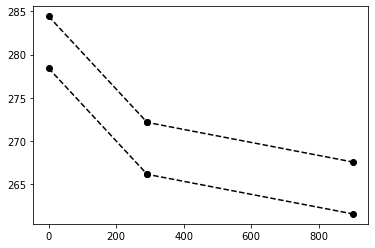

In [527]:
def plotter(sections):
    """Playing with plotting.
    """
    xdata = []
    ydata = []
    ydata_top = []
    xbase = 0
    for sec in sections:
        Z = (sec.z2 - sec.z1)
        X = np.sqrt(sec.length**2 - Z**2)
        xdata += [xbase, xbase + X]
        ydata += [sec.z1, sec.z2]
        ydata_top += [sec.z1 + sec.diam, sec.z2 + sec.diam]
        # theta = np.arctan(np.abs(sec.z2-sec.z1)/X)
        # beta = np.pi/2 - theta
        # x = sec.diam * np.cos(beta)
        # y = x * np.tan(beta)
        # a = np.tan(theta) * x
        # delta = y + a
        # ydata_top += [sec.z1+delta, sec.z2+delta]
        xbase = xbase + X
    plt.plot(xdata, ydata, 'o--', c='k')
    plt.plot(xdata, ydata_top, 'o--', c='k')
    
plotter([sec1, sec2])

In [439]:
sum([s.length for s in outlet.sections])
[(s.z1, s.z2) for s in outlet.sections]

[(278.43, 272.295), (272.295, 266.16), (266.16, 263.87), (263.87, 261.58)]

In [374]:
# Plot combined open channel and pressurized flow?